# 1	Draft Data Dictionary Land Management Schemes [Oct 2020]

## Introduction

The area managed under agri-environment agreements: ie the total area under Environmental Stewardship (ES), Countryside Stewardship (CS) (including its different levels), and area under England Woodland Grant Scheme (EWGS)

**ES** is an agri-environment scheme which provides funding to farmers and other land managers in England who deliver effective environmental management on their land.

It has four elements:
•	Entry Level Stewardship (ELS)
•	Organic Entry Level Stewardship (OELS)
•	Uplands Entry Level Stewardship (Uplands ELS)
•	Higher Level Stewardship (HLS).

Upland ELS can apply to any agreement with an ELS or OELS component and therefore their figures are subsumed in the ELS, ELS/HLS, OELS and OELS/HLS categories.

**CS** is an agri-environment scheme with Higher Tier, full Mid tier, Mid Tier wildlife packages and Hedgerows and Boundaries grant schemes.

The Countryside Stewardship Scheme was originally an agri-environment scheme run by the United Kingdom Government set up in 1991. In its original form it expired in 2014. It was relaunched for the Rural Development Programme England (RDPE) 2014-2020 with £3.1bn of government subsidy for agriculture and forestry, replacing the previous Environmental Stewardship scheme.

**EWGS** is the legacy England Woodland Grant Scheme by the Forestry Commission

The PDNPA also has it's own small scale Land Management Grant Scheme not currently in this analysis.

## Manage the GIS

In [22]:
from arcgis import GIS
from arcgis.features.manage_data import extract_data
import arcpy
import os
import pandas
gis = GIS("Pro")
print(gis)

GIS @ https://www.arcgis.com/ version:8.3


In [24]:
# setup the environment
arcpy.env.addOutputsToMap = True
arcpy.env.overwriteOutput = True
arcpy.env.workspace = 'C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/data'
outgdb = 'C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/Land Management Schemes.gdb'

## Data used in this analysis

Use the ESRI living Atlas layers as the sources of data

In [4]:
# find the data
CS_item = gis.content.get('dd63fbfeda8e48878eb19db84883147b')
ES_item = gis.content.get('ca68c90958c342a285d6370ddd7edd66')
EWGS_1_item = gis.content.get('d527d55fd5104e80b1bf2d80643f5865')
EWGS_3_item = gis.content.get('3e26fc54a1d4479f90d5f268cc83a0a9')
PDNP_item = gis.content.get('73dc1cbc587f4e518a0010dceb9eab24')

<Item title:"Countryside Stewardship Scheme Agreements (England)" type:Feature Layer Collection owner:Opendata_NE>
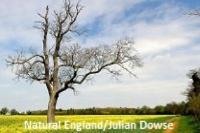

<Item title:"Environmental Stewardship Scheme Agreements (England)" type:Feature Layer Collection owner:Opendata_NE>
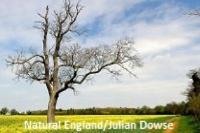

<Item title:"Woodland Grant Scheme 1 England" type:Feature Layer Collection owner:mapping.geodata_forestry>
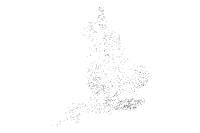

<Item title:"Woodland Grant Scheme 3 England" type:Feature Layer Collection owner:mapping.geodata_forestry>
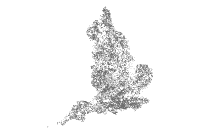

<Item title:"PDNP" type:Feature Layer Collection owner:david.alexander_PDNPA>
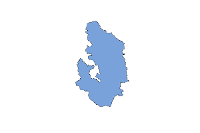

In [5]:
# display the items
data = [CS_item, ES_item, EWGS_1_item, EWGS_3_item, PDNP_item]
for item in data:
    display(item)

In [10]:
# download the data
CS_gbd = extract_data([CS_item], data_format = 'Shapefile')
CS_gbd.download('C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/data')
ES_gbd = extract_data([ES_item], data_format = 'Shapefile')
ES_gbd.download('C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/data')
PDNP_gbd = extract_data([PDNP_item], data_format = 'Shapefile')
PDNP_gbd.download('C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/data')

In [20]:
# add the data to the geodatabase
fcs = arcpy.ListFeatureClasses()
for fc in fcs:
    desc = arcpy.da.Describe(fc)
    outfc = os.path.join(outgdb, desc["baseName"])
    arcpy.CopyFeatures_management(fc, outfc)

## Data preprocessing

In [21]:
# Clip the data to the PDNP National Park
arcpy.Clip_analysis("Environmental_Stewardship_Scheme_Agreements__England____Natural_England.shp", "PDNP.shp", "ES_clip.shp")
arcpy.Clip_analysis("Countryside_Stewardship_Scheme_Agreements___Natural_England.shp", "PDNP.shp", "CS_clip.shp")

<Result 'C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/data\\CS_clip.shp'>

## Environmental Stewardship Processing

Call **geopandas** to create a df and use **Pandas** for data processing

In [36]:
import geopandas as gpd
import pandas as pd
ES_clip_gdf = gpd.read_file("C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/data/ES_clip.shp")

In [37]:
# take a look at the first 2 rows of the df
ES_clip_gdf.head(2)

,FID_1,AGREF,CPH,CUSTNAME,TOWN,SCHEME,REGION,NCA,LAND_CTY,ELSAREA,HLSAREA,APPSTAT,LIVEDATE,STARTDAT,OPTSONAG,TILE,ENDDATE,RDA_NAME,GROSSAR,TOTCOST,AMTPAID,NUMPARCS,ARUAGR,PERMACS,EDUACS,UELSFLG,BUS_FLAG,SHAPE_Leng,SHAPE_Area,geometry
0,44,AG00267487,090830045,P W Wood,Buxton,Entry Level plus Higher Level Stewardship,East Midlands,WHITE PEAK,Derbyshire,2013.27,3285.87,Live,26/10/2009,01/10/2009,"A13,EA1,EB11,EL6,FDS,FEP,FSH,GF,HK16,HK6,HL10,...",SK,30/09/2021,East Midlands Area Team,95.87,144685.65,112089.23,5.0,95.87,NULL,N,N,N,8261.294114,9.586792e+05,"MULTIPOLYGON (((419506.820 373301.300, 419510...."
1,152,AG00284627,090658009,Peak District National Park Authority,Bakewell,Higher Level Stewardship,West Midlands,SOUTH WEST PEAK,Staffordshire,0.00,11970.25,Live,01/07/2010,01/07/2010,"A13,CCG,FDS,FEP,FSH2010,GBD,GF,HC7,HC8,HK16,HK...",SJ,30/06/2020,East Midlands Area Team,412.45,419061.44,403596.88,93.0,412.45,NULL,N,N,Y,50600.853088,4.124155e+06,"MULTIPOLYGON (((408334.600 358845.150, 408402...."


Create a new column **[END_YEAR]** and extract the calendar year from **[ENDDATE]** in the dataframe

In [38]:
ES_clip_gdf['END_YEAR'] = pd.DatetimeIndex(ES_clip_gdf['ENDDATE']).year

Create a new column **[AREA_CLIP]** using the clipped **geometry** and add the calculated area (as data has been clipped some agreements overlap the boundary). This new column shows the area (sqkm) just inside the National Parks boundary.

In [39]:
ES_clip_gdf['AREA_CLIP'] = ES_clip_gdf['geometry'].area/10**6

In [40]:
# take a look at the first 2 rows of the df to check :)
ES_clip_gdf.head(2)

,FID_1,AGREF,CPH,CUSTNAME,TOWN,SCHEME,REGION,NCA,LAND_CTY,ELSAREA,HLSAREA,APPSTAT,LIVEDATE,STARTDAT,OPTSONAG,TILE,ENDDATE,RDA_NAME,GROSSAR,TOTCOST,AMTPAID,NUMPARCS,ARUAGR,PERMACS,EDUACS,UELSFLG,BUS_FLAG,SHAPE_Leng,SHAPE_Area,geometry,END_YEAR,AREA_CLIP
0,44,AG00267487,090830045,P W Wood,Buxton,Entry Level plus Higher Level Stewardship,East Midlands,WHITE PEAK,Derbyshire,2013.27,3285.87,Live,26/10/2009,01/10/2009,"A13,EA1,EB11,EL6,FDS,FEP,FSH,GF,HK16,HK6,HL10,...",SK,30/09/2021,East Midlands Area Team,95.87,144685.65,112089.23,5.0,95.87,NULL,N,N,N,8261.294114,9.586792e+05,"MULTIPOLYGON (((419506.820 373301.300, 419510....",2021,0.958679
1,152,AG00284627,090658009,Peak District National Park Authority,Bakewell,Higher Level Stewardship,West Midlands,SOUTH WEST PEAK,Staffordshire,0.00,11970.25,Live,01/07/2010,01/07/2010,"A13,CCG,FDS,FEP,FSH2010,GBD,GF,HC7,HC8,HK16,HK...",SJ,30/06/2020,East Midlands Area Team,412.45,419061.44,403596.88,93.0,412.45,NULL,N,N,Y,50600.853088,4.124155e+06,"MULTIPOLYGON (((408334.600 358845.150, 408402....",2020,4.124155


# Data Analysis

### What is the area of land in Environmental Stewardship Agreements?

In [41]:
Total_ES_area = ES_clip_gdf['AREA_CLIP'].sum()
print (Total_ES_area, "sq km")

644.9434492251772 sq km


### By year, what is the area of land by which Environmental Stewardship agreements will be ending?

In [42]:
print(ES_clip_gdf.groupby(by=['AREA_CLIP', 'END_YEAR']).sum().groupby(level=[0]).cumsum())

                    FID_1   ELSAREA  ...    SHAPE_Leng    SHAPE_Area
AREA_CLIP END_YEAR                   ...                            
0.000019  2020       3035    140.80  ...   1685.470647  7.011354e+04
0.000663  2023       7731      0.00  ...   3606.522527  5.094168e+05
0.002861  2022       5314    161.85  ...   2768.683673  1.244791e+05
0.005188  2023       6407    426.14  ...   4129.599755  3.275377e+05
0.010778  2020       9663      0.00  ...    545.667853  1.261819e+04
...                   ...       ...  ...           ...           ...
19.021314 2022       5685  45650.64  ...  96662.554214  1.902131e+07
22.682059 2023       5143  38562.80  ...  34973.649504  2.268206e+07
23.135559 2023       5008  41643.72  ...  39874.368738  2.313556e+07
24.110626 2023       8175  31344.95  ...  58879.259458  2.411173e+07
24.479624 2022       5485  63647.22  ...  51232.656512  2.447962e+07

[341 rows x 7 columns]


### What does the data look like?